<a href="https://colab.research.google.com/github/osjayaprakash/deeplearning/blob/main/CS_230_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## cs230 project

In [43]:
import kagglehub

# Download latest version
root_dir = kagglehub.dataset_download("shahrukhkhan/im2latex100k")
# path = kagglehub.dataset_download("gregoryeritsyan/im2latex-230k")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7


In [44]:
print(root_dir)
!ls {root_dir}

/root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7
formula_images_processed    im2latex_test.csv	im2latex_validate.csv
im2latex_formulas.norm.csv  im2latex_train.csv


In [45]:
import pandas as pd

df = pd.read_csv(f"{root_dir}/im2latex_train.csv", nrows=1000)

In [16]:
df.head()

,formula,image
0,\widetilde \gamma _ { \mathrm { h o p f } } \s...,66667cee5b.png
1,"( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \...",1cbb05a562.png
2,S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ...,ed164cc822.png
3,\hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a ...,e265f9dc6b.png
4,"\, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } ...",242a58bc3a.png


In [12]:
df["image"].describe()

,image
count,75275
unique,75262
top,4475b822a2.png
freq,2


In [13]:
df["formula"].describe()

,formula
count,75275
unique,74878
top,\begin{array} { r c l } \end{array}
freq,22


In [14]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd

import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [80]:
df_train = pd.read_csv(f"{root_dir}/im2latex_train.csv", nrows=1000)
df_train.head()

,formula,image
0,\widetilde \gamma _ { \mathrm { h o p f } } \s...,66667cee5b.png
1,"( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \...",1cbb05a562.png
2,S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ...,ed164cc822.png
3,\hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a ...,e265f9dc6b.png
4,"\, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } ...",242a58bc3a.png


In [81]:
df_test = pd.read_csv(f"{root_dir}/im2latex_test.csv", nrows=10)
df_test.head()

,formula,image
0,\alpha _ { 1 } ^ { r } \gamma _ { 1 } + \dots ...,7944775fc9.png
1,\eta = - \frac { 1 } { 2 } \operatorname { l n...,78228211ca.png
2,P _ { ( 2 ) } ^ { - } = \int \beta d \beta d ^...,15b9034ba8.png
3,\Gamma ( z + 1 ) = \int _ { 0 } ^ { \infty } \...,6968dfca15.png
4,\frac { d } { d s } { \bf C } _ { i } = \frac ...,6cead0df53.png


In [82]:
df_valid = pd.read_csv(f"{root_dir}/im2latex_validate.csv", nrows=10)
df_valid.head()

,formula,image
0,\int _ { - \epsilon } ^ { \infty } d l \: \mat...,5abbb9b19f.png
1,"[ { \bar { K } } _ { a } ^ { - } ( p ) , { \ba...",329a44c373.png
2,E ( v ) = \frac { d } { d t } E ( q ) \; \; \;...,73b51f198b.png
3,{ \frac { 1 } { L ^ { 2 } } } \prod _ { i = 1 ...,6331d9e7fd.png
4,"x ^ { I } ( \sigma + 2 \pi , \tau ) = x ^ { I ...",91a55d2cb9.png


In [83]:
df_train["image"] = df_train["image"].apply(lambda x: root_dir + "/formula_images_processed/formula_images_processed/" + x)
df_test["image"] = df_test["image"].apply(lambda x: root_dir + "/formula_images_processed/formula_images_processed/"  + x)
df_valid["image"] = df_valid["image"].apply(lambda x: root_dir + "/formula_images_processed/formula_images_processed/"  + x)

df_train["image"] = df_train["image"].apply(lambda x: x if x.endswith(".png") else np.nan)
df_test["image"] = df_test["image"].apply(lambda x: x if x.endswith(".png") else np.nan)
df_valid["image"] = df_valid["image"].apply(lambda x: x if x.endswith(".png") else np.nan)

df_train = df_train.dropna().reset_index(drop=True)
df_valid = df_valid.dropna().reset_index(drop=True)
df_test = df_test.dropna().reset_index(drop=True)

In [84]:
train_characters = set(char for formula in df_train['formula'] for char in formula)
test_characters = set(char for formula in df_test['formula'] for char in formula)
valid_characters = set(char for formula in df_valid['formula'] for char in formula)
train_characters.update(test_characters)
train_characters.update(valid_characters)
characters = train_characters
print(f"Characters ({len(characters)}):\n", characters)

Characters (88):
 {'p', 'R', 'Q', 'u', '3', ' ', '&', 'L', '\\', 'e', 'b', 'r', 'V', 'k', "'", 'w', 'P', 's', 'm', '8', '/', '_', ']', '-', 'I', 'h', ':', '}', '!', 'c', 'o', '[', 'G', 'l', '>', 'S', 'J', '(', 'f', ',', 'B', '9', '=', 'U', '~', 'C', 'q', '1', 'F', 'g', 'H', 't', ')', '*', 'a', 'Z', '4', 'K', 'i', 'X', 'Y', '<', '{', 'D', 'z', '2', ';', '.', 'x', '6', 'O', 'y', '|', '7', 'W', '5', 'N', 'A', 'v', 'M', 'n', '^', 'j', 'E', '+', 'T', 'd', '0'}


In [85]:
char_to_num = layers.StringLookup(
    vocabulary = list(characters),
    num_oov_indices = 0,
    mask_token = None
)

In [86]:
pd.DataFrame({"char": char_to_num.get_vocabulary(),
              "num": np.arange(1, len(char_to_num.get_vocabulary())+1)})

,char,num
0,p,1
1,R,2
2,Q,3
3,u,4
4,3,5
...,...,...
83,E,84
84,+,85
85,T,86
86,d,87


In [87]:
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [88]:
@tf.function
def encode_single_sample(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [50, 200])
    image = tf.transpose(image, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    label = tf.pad(label, paddings=[[0, 600 - tf.shape(label)[0]]], constant_values=0)
    return {"Input": image, "Label": label}, label

In [89]:
@tf.function
def process_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.map(encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(1024).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [90]:
X_train = df_train['image'].values.tolist()
y_train = df_train['formula'].values.tolist()
X_valid = df_valid['image'].values.tolist()
y_valid = df_valid['formula'].values.tolist()
X_test = df_test['image'].values.tolist()
y_test = df_test['formula'].values.tolist()

train_dataset = process_dataset(X_train, y_train)
valid_dataset = process_dataset(X_valid, y_valid)
test_dataset = process_dataset(X_test, y_test)

In [91]:
train_dataset = process_dataset(X_train, y_train)
valid_dataset = process_dataset(X_valid, y_valid)
test_dataset = process_dataset(X_test, y_test)

In [92]:
def visualize_df(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 1, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image']].values[0]
            label = df.loc[a][["formula"]].values[0]

            image = Image.open(img_path).convert('RGB')

            ax.imshow(image)
            ax.set_title(f"LateX: {label}")
            ax.axis('off')

        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [93]:
df_train.head()

,formula,image
0,\widetilde \gamma _ { \mathrm { h o p f } } \s...,/root/.cache/kagglehub/datasets/shahrukhkhan/i...
1,"( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \...",/root/.cache/kagglehub/datasets/shahrukhkhan/i...
2,S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ...,/root/.cache/kagglehub/datasets/shahrukhkhan/i...
3,\hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a ...,/root/.cache/kagglehub/datasets/shahrukhkhan/i...
4,"\, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } ...",/root/.cache/kagglehub/datasets/shahrukhkhan/i...


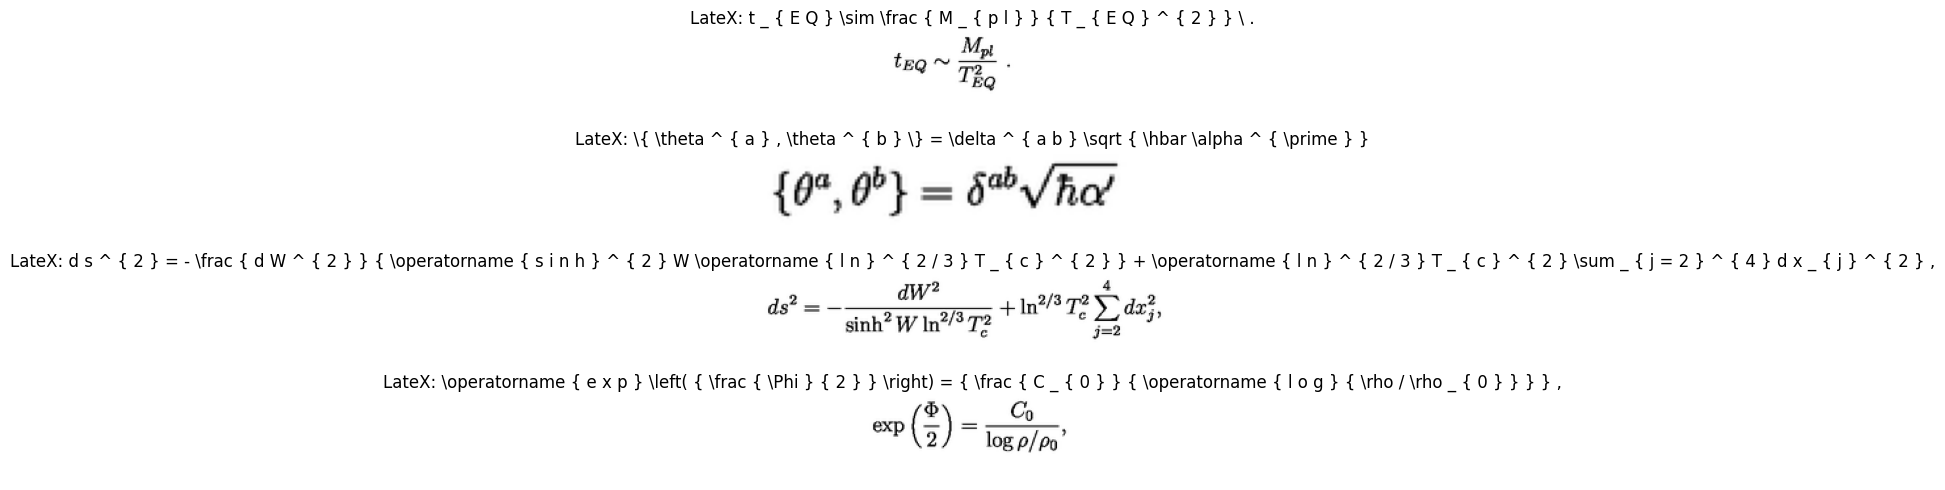

In [94]:
visualize_df(df_train)

In [95]:
#!ls /root/.cache/kagglehub/datasets/shahrukhkhan/im2latex100k/versions/7/formula_images_processed/formula_images_processed/

In [109]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_length = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_length, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_length, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length, ignore_longer_outputs_than_inputs=True)
        self.add_loss(loss)

        return y_pred

In [110]:
input_shape = (200, 50, 1)
num_classes = len(characters) + 1  # +1 for the CTC blank label

input_layer = layers.Input(shape=input_shape, name="Input", dtype="float32")
label_layer = layers.Input(shape=(None,), name="Label", dtype="float32")

conv2_1 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_layer)
max2_1 = layers.MaxPooling2D(pool_size=(2, 2))(conv2_1)

conv2_2 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(max2_1)
max2_2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2_2)

reshape_shape = (input_shape[0] // 4, (input_shape[1] // 4) * 64)
reshape_layer = layers.Reshape(target_shape=reshape_shape)(max2_2)

dense_1 = layers.Dense(units=64, activation="relu")(reshape_layer)
drop_1 = layers.Dropout(0.2)(dense_1)

bilstm_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(drop_1)
bilstm_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(bilstm_1)

output_layer = layers.Dense(num_classes, activation="softmax", name="Output")(bilstm_2)

output = CTCLayer(name="ctc_loss")(label_layer, output_layer)

model = models.Model(inputs=[input_layer, label_layer], outputs=output, name="OCR")

TypeError: Exception encountered when calling CTCLayer.call().

[1mCould not automatically infer the output shape / dtype of 'ctc_loss' (of type CTCLayer). Either the `CTCLayer.call()` method is incorrect, or you need to implement the `CTCLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

ctc_batch_cost() got an unexpected keyword argument 'ignore_longer_outputs_than_inputs'[0m

Arguments received by CTCLayer.call():
  • args=('<KerasTensor shape=(None, None), dtype=float32, sparse=None, name=Label>', '<KerasTensor shape=(None, 50, 89), dtype=float32, sparse=False, name=keras_tensor_42>')
  • kwargs=<class 'inspect._empty'>

In [105]:
model.compile(optimizer=optimizers.Adam())
model.summary()

Model: "OCR"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)        │ (None, 200, 50, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 200, 50, 32)    │            320 │ Input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 100, 25, 32)    │              0 │ conv2d_4[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 100, 25, 64)    │         18,496 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 50, 12, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 50, 768)        │              0 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 50, 64)         │         49,216 │ reshape_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 50, 64)         │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 50, 256)        │        197,632 │ dropout_2[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 50, 128)        │        164,352 │ bidirectional_4[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Label (InputLayer)        │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output (Dense)            │ (None, 50, 89)         │         11,481 │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ctc_loss (CTCLayer)       │ (None, 50, 89)         │              0 │ Label[0][0],           │
│                           │                        │                │ Output[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 441,497 (1.68 MB)

 Trainable params: 441,497 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

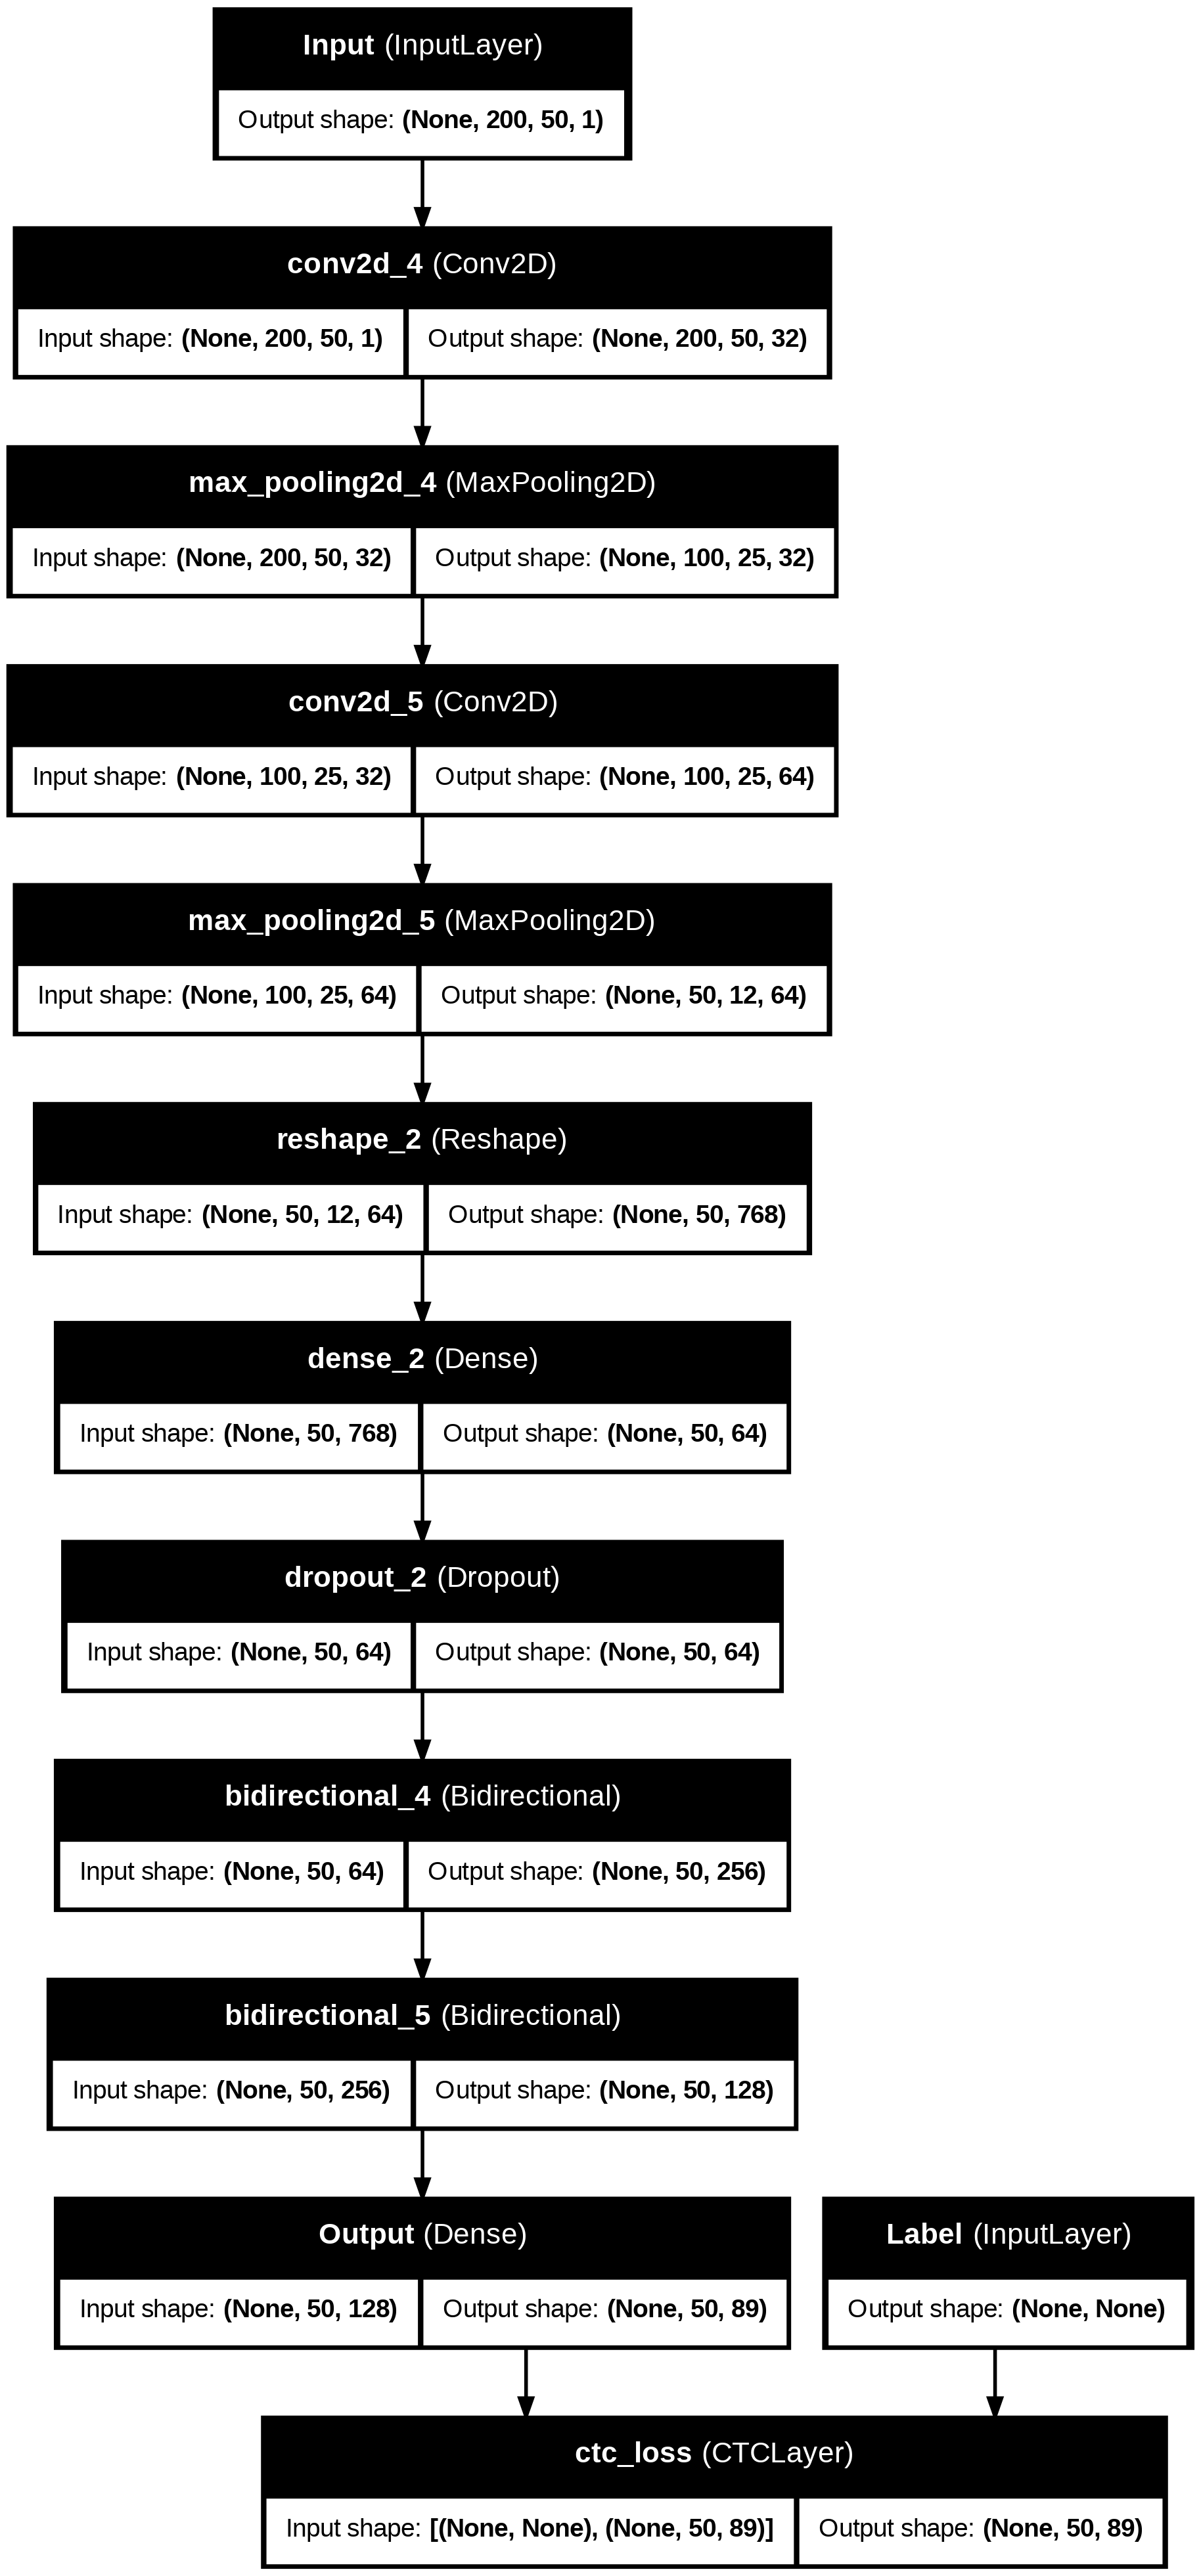

In [106]:
plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

In [107]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [108]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=100,
    # callbacks=[early_stopping]
)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node OCR_1/ctc_loss_1/CTCLoss defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-108-32a4bf084c53>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 556, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "<ipython-input-103-938116bc9c73>", line 14, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/legacy/backend.py", line 666, in ctc_batch_cost

Not enough time for target transition sequence (required: 600, available: 50)0You can turn this error into a warning by using the flag ignore_longer_outputs_than_inputs
	 [[{{node OCR_1/ctc_loss_1/CTCLoss}}]] [Op:__inference_one_step_on_iterator_20230]